In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import math 
import re
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import sent_tokenize 
from nltk.corpus import stopwords
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [2]:
class Sentiment_Analyzer():
    def __init__(self,tweets):
        self.tweets = tweets
        
    def first(self):
        clean_tweets = []
        new_tweet_lexicon = {}
        tags_count = {}
        bigrams = {}
        all_tags = []
        for tw in self.tweets:
            Pp = preProcessing(tw)
            Pp.extractRegex()
            Pp.firstClean()
            Pp.lemWords()
            Pp.stemWords()
            Pp.wordTokenize()
            final_tokens = Pp.stopWords()
            clean_tweets.append(' '.join(final_tokens))  
            #print(final_tokens)

            tags = nltk.pos_tag(final_tokens)
            tags.insert(0,(" ",'-s-'))
            all_tags.append(tags)
            
            #lexicon
            for i in range(1,len(tags)):  #new:lexicon
                j = i-1
                if tags[i][0] in new_tweet_lexicon:
                    new_tweet_lexicon[tags[i][0]]['ocurrences'] +=1
                    new_tweet_lexicon[tags[i][0]]['tags'].append(tags[i][1])
                    #new_tweet_lexicon[tags[j][0]]['next_tags'].append(tags[i][1])
                else:
                    key = tags[i][0]
                    values = {'ocurrences': 1, 'tags': [tags[i][1]]}#, 'next_tags': [tags[i][1]]}
                    new_tweet_lexicon[key] = values

                #Getting the bigrams ocurrences
                if (tags[j][1],tags[i][1]) in bigrams:
                    bigrams[(tags[j][1],tags[i][1])]['ocurrences'] +=1
                else:
                    key = (tags[j][1],tags[i][1])
                    values = {'ocurrences': 1}
                    bigrams[key] = values
            
            #counting tags occurrences
            for tag in tags:
                if tag[1] not in tags_count.keys():
                    tags_count[tag[1]] = 1
                else: 
                    tags_count[tag[1]] += 1
            
        for e in new_tweet_lexicon.keys():
            entry = new_tweet_lexicon[e]
            #print(e)
            entry['tags'] = SA.countTags(entry['tags'],tags_count)
            #entry['next_tags'] = SA.countTags(entry['next_tags'],tags_count)
            new_tweet_lexicon[e] = entry
            
        ambiguous = []
        determined = []
        for word in new_tweet_lexicon.keys():
            entry = new_tweet_lexicon[word]
            tags = ",".join(entry['tags'].keys())
            if len(entry['tags'].keys()) > 1:
                ambiguous.append(word)
            else:
                determined.append(word)
        
        return new_tweet_lexicon,tags_count,bigrams,all_tags,ambiguous,determined,clean_tweets
        
    def countTags(self,list_tags,tags_count):  #count the tags in the list for each word
        counts = {}
        total = 0
        for tag in list_tags:
            if tag in counts.keys():
                counts[tag] += 1
            else:
                counts[tag] = 1
            total += 1
        for tag in counts.keys():
            ocurrences = counts[tag]
            counts[tag] = {'ocurrences': ocurrences, 'emission_prob': ocurrences/tags_count[tag]}
        return counts
    
    def probability(self, lexicon,tags_count,bigrams,all_tags): #POS tag and probabilities 
        probs = {}  #all posible bigrams and their prob per tweet
        count = 0
        for str_tags in all_tags:
            probs[count] = {}
            for i in range(1,len(str_tags)):
                j = i-1
                if (str_tags[j][1],str_tags[i][1]) in bigrams.keys():
                    if (str_tags[j][1],str_tags[i][1]) not in probs[count].keys():
                        probs[count][(str_tags[j][1],str_tags[i][1])] = (1/bigrams[(str_tags[j][1],str_tags[i][1])]['ocurrences'])
                    else: probs[count][(str_tags[j][1],str_tags[i][1])] += (1/bigrams[(str_tags[j][1],str_tags[i][1])]['ocurrences'])
                else: probs[count][(str_tags[j][1],str_tags[i][1])] = 1
            count += 1
            
        #Getting prob of possible tags a word have 
        word_tag_prob = {}
        for word in lexicon.keys():
            word_tag_prob[word] = {}
            for tag,t in lexicon[word]['tags'].items():
                p = t['ocurrences']/tags_count[tag]
                word_tag_prob[word][tag] = p
        
        #Transitions prob
        trans_p = {}
        for bigram in bigrams.keys():
            p1 = bigrams[bigram]['ocurrences']/tags_count[bigram[0]]
            trans_p[bigram] = p1
        
        return  probs,word_tag_prob,trans_p
    
    def post_tag(self,string,lexicon,ambiguous,determined,trans_p):
        #string has to be tags, list of tuples (word,tag)
        TAGS = {}
        for t in range(len(string)):
            sentence = [(' ','-s-')]
            for i in range(1,len(string[t])):
                j = i-1
                prob_value = 1
                if string[t][i][0] in ambiguous:
                    for wtag in lexicon[string[t][i][0]]['tags'].keys():
                        if (string[t][j][1],wtag) in trans_p:
                            p = 0
                            if (trans_p[(string[t][j][1],wtag)] * lexicon[string[t][i][0]]['tags'][wtag]['emission_prob'])  > p:
                                prob_value = (trans_p[(string[t][j][1],wtag)] * lexicon[string[t][i][0]]['tags'][wtag]['emission_prob']*prob_value)
                                p = prob_value
                                best_tag = wtag
                            else: continue
                    sentence.append((string[t][i][0],best_tag))
                    #string[t][i][1] = best_tag
                    #prob_value = (trans_p[(string[t][i][1],wtag)] * lexicon[string[t][i][0]]['tags'][wtag]['emission_prob'])
                else: 
                    sentence.append(string[t][i])
                    if (sentence[j][1],string[t][i][1]) not in trans_p:
                        prob_value = 1
                    else:
                        prob_value = (trans_p[(sentence[j][1],string[t][i][1])] * lexicon[string[t][i][0]]['tags'][string[t][i][1]]['emission_prob']*prob_value)
            TAGS[prob_value] = sentence
    
        return TAGS
    
    
    def TF_IDF(sefl,tweet, lexicon):
        List_of_list = np.zeros((len(tweet),len(lexicon)), dtype=np.float64)
        for t in range (len(tweet)):
            for i in range(len(lexicon)):
                if lexicon[i] in tweet[t]:
                    List_of_list[t][i] = List_of_list[t][i]+1

        idf = np.zeros((len(tweet),len(lexicon)), dtype=np.float64)
        word_docs=[]
        a=0

        for i in range(len(List_of_list)):
            number_words = 0
            for all in List_of_list[i]:
                if all != 0:
                    number_words = number_words+1   
            word_docs.append(number_words)
        for i in range(len(List_of_list)):
            for x in range(len(List_of_list[i])):
                TF=List_of_list[i][x]/word_docs[i]
                for j in range(len(List_of_list)):
                    if List_of_list[j][x] != 0:
                        a=a+1
                IDF = math.log(len(List_of_list)/(1+a)) #log (len total tweets/ # of twts were word appears)
                idf[i][x]=abs(TF*IDF)
        return idf

In [3]:
class preProcessing():
    def __init__(self,tweet,special_chars="/,.:;?!¬-_\"''=()%&$#"):
        self.string = tweet.lower()
        self.special_chars = special_chars
        self.sw = stop_words = set(stopwords.words('english'))
        self.wc = words_corp = set(nltk.corpus.words.words())
        self.rdict = regex_dict = {'email':('((\w)*\.?)+@((\w)*\.?)+\.(mx|com)','e-mail'),'not': ("n\'t"," not"), 'are':("\'re", " are"), 'is':("\'s", " is"),'would': ("\'d", "would"),'will': ("\'ll", " will"), 'have':("\'ve", " have"), 'am': ("\'m", " am"), 'int': ('\w*\d\w*', ''), 'n': ("\'n", ''), 'url': ('http?:.*(?=\s)','url')}
        self.tokenizer = TweetTokenizer()
        self.lm = WordNetLemmatizer()  #Lemmatizer
        self.ps = PorterStemmer()  #Steammer
    
    def extractRegex(self):
        txt = self.string
        for regx,rep_name in list(self.rdict.values()):  #When a regex in dict cmatch with a word, that words is replaced with rgx name_value
            txt = re.sub(regx,rep_name,txt)
        self.string = txt 
        return self.string
    
    
    def firstClean(self):
        cleansed_string = self.string
        for char in self.special_chars+"@€™ðŸŒŽðŸâœï~":
            cleansed_string = cleansed_string.replace(char, '')
            self.string = cleansed_string
        return self.string
    
    def cleanString(self):
        clean_string = self.string
        cleaned_words = []
        for char in self.special_chars:
            clean_string = clean_string.replace(char, '')
            for word in clean_string.split(" "):
                clean_word = word.replace(" ", "")
                if len(clean_word) > 0 and clean_word not in cleaned_words:
                    cleaned_words.append(word.replace(" ", ""))
        self.string = " ".join(cleaned_words)
        return self.string
    
    def lemWords(self):
        lem_words = []
        
        for word in self.string.split(" "):
            lem_words.append(self.lm.lemmatize(word,pos='a'))
        lematized = ' '.join(lem_words)  #String with all lemmatized words
        self.string = lematized
        return self.string
    
    def stemWords(self):
        roots=[]
        
        for word in self.string.split(" "):
            roots.append(self.ps.stem(word))
        stemmed = ' '.join(roots)  #String with all words root
        self.string = stemmed
        return self.string
    
    def wordTokenize(self):
        #Twitter tokenizer was used to consider emojis, hastags and user names while tokenizing
        tokenized = ' '.join(self.tokenizer.tokenize(self.string))
        self.string = tokenized
        return self.string
    
    def stopWords(self):
        new_sentence = []
        for word in self.string.split(" "):
            if word not in self.sw:   #Removing stopwords
                new_sentence.append(word)
            else: continue
        #cleaned = ' '.join(new_sentence)  #Str without stopw
        #self.string = cleaned
        return new_sentence

In [4]:
df = pd.read_csv('tweets.csv',sep=",")
print(df.head())

                                               tweet  senti
0  @united Oh, we are sure it's not planned, but ...      0
1                          History exam studying ugh      0
2  @unnitallman yeah looks like that only! &quot;...      0
3                                      Loves twitter      4
4  @Mbjthegreat i really dont want AT&amp;T phone...      0


In [5]:
#Analyzer (class)
SA = Sentiment_Analyzer(df['tweet'])

In [6]:
lexicon,tags_count,bigrams,all_tags,amb,det,clean_tweets = SA.first()

In [7]:
lexicon

{'unit': {'ocurrences': 28,
  'tags': {'NN': {'ocurrences': 28, 'emission_prob': 0.018360655737704918}}},
 'oh': {'ocurrences': 7,
  'tags': {'JJ': {'ocurrences': 2, 'emission_prob': 0.0044742729306487695},
   'RB': {'ocurrences': 2, 'emission_prob': 0.02},
   'UH': {'ocurrences': 3, 'emission_prob': 1.0}}},
 'sure': {'ocurrences': 1,
  'tags': {'JJ': {'ocurrences': 1, 'emission_prob': 0.0022371364653243847}}},
 'plan': {'ocurrences': 4,
  'tags': {'NN': {'ocurrences': 4, 'emission_prob': 0.002622950819672131}}},
 'occur': {'ocurrences': 1,
  'tags': {'VBP': {'ocurrences': 1, 'emission_prob': 0.009433962264150943}}},
 'absolut': {'ocurrences': 3,
  'tags': {'JJ': {'ocurrences': 1, 'emission_prob': 0.0022371364653243847},
   'VBD': {'ocurrences': 1, 'emission_prob': 0.012658227848101266},
   'NN': {'ocurrences': 1, 'emission_prob': 0.0006557377049180328}}},
 'consist': {'ocurrences': 1,
  'tags': {'VBP': {'ocurrences': 1, 'emission_prob': 0.009433962264150943}}},
 'usual': {'ocurrences'

In [8]:
tags_count

{'-s-': 298,
 'NN': 1525,
 'JJ': 447,
 'VBP': 106,
 'IN': 63,
 'PRP': 10,
 'NNS': 49,
 'VBD': 79,
 'DT': 5,
 'MD': 23,
 'VB': 115,
 'RB': 100,
 'VBN': 19,
 'JJR': 1,
 'CD': 13,
 'FW': 7,
 'RP': 3,
 'WRB': 4,
 'VBZ': 22,
 'JJS': 4,
 'UH': 3,
 'NNP': 33,
 'RBS': 1,
 'WDT': 1}

In [9]:
#Bigrams's probabilities
bigrams

{('-s-', 'NN'): {'ocurrences': 170},
 ('NN', 'JJ'): {'ocurrences': 131},
 ('JJ', 'JJ'): {'ocurrences': 62},
 ('JJ', 'NN'): {'ocurrences': 320},
 ('NN', 'VBP'): {'ocurrences': 57},
 ('VBP', 'JJ'): {'ocurrences': 29},
 ('JJ', 'VBP'): {'ocurrences': 4},
 ('NN', 'NN'): {'ocurrences': 848},
 ('NN', 'IN'): {'ocurrences': 44},
 ('-s-', 'JJ'): {'ocurrences': 55},
 ('JJ', 'PRP'): {'ocurrences': 3},
 ('PRP', 'VBP'): {'ocurrences': 1},
 ('VBP', 'IN'): {'ocurrences': 4},
 ('IN', 'NNS'): {'ocurrences': 2},
 ('NNS', 'VBP'): {'ocurrences': 31},
 ('NN', 'NNS'): {'ocurrences': 20},
 ('VBP', 'VBP'): {'ocurrences': 1},
 ('NN', 'VBD'): {'ocurrences': 56},
 ('VBD', 'JJ'): {'ocurrences': 41},
 ('VBP', 'DT'): {'ocurrences': 1},
 ('DT', 'NN'): {'ocurrences': 2},
 ('NN', 'MD'): {'ocurrences': 16},
 ('MD', 'VB'): {'ocurrences': 21},
 ('VB', 'JJ'): {'ocurrences': 42},
 ('JJ', 'VBD'): {'ocurrences': 3},
 ('-s-', 'VBD'): {'ocurrences': 8},
 ('IN', 'JJ'): {'ocurrences': 19},
 ('NN', 'RB'): {'ocurrences': 33},
 ('JJ

In [10]:
#New funct in class
probs,word_tag_prob,trans_p = SA.probability(lexicon,tags_count,bigrams,all_tags)

In [11]:
#Transition probabilities (bigrams)
trans_p

{('-s-', 'NN'): 0.5704697986577181,
 ('NN', 'JJ'): 0.0859016393442623,
 ('JJ', 'JJ'): 0.13870246085011187,
 ('JJ', 'NN'): 0.7158836689038032,
 ('NN', 'VBP'): 0.037377049180327866,
 ('VBP', 'JJ'): 0.27358490566037735,
 ('JJ', 'VBP'): 0.008948545861297539,
 ('NN', 'NN'): 0.5560655737704918,
 ('NN', 'IN'): 0.028852459016393443,
 ('-s-', 'JJ'): 0.18456375838926176,
 ('JJ', 'PRP'): 0.006711409395973154,
 ('PRP', 'VBP'): 0.1,
 ('VBP', 'IN'): 0.03773584905660377,
 ('IN', 'NNS'): 0.031746031746031744,
 ('NNS', 'VBP'): 0.6326530612244898,
 ('NN', 'NNS'): 0.013114754098360656,
 ('VBP', 'VBP'): 0.009433962264150943,
 ('NN', 'VBD'): 0.036721311475409836,
 ('VBD', 'JJ'): 0.5189873417721519,
 ('VBP', 'DT'): 0.009433962264150943,
 ('DT', 'NN'): 0.4,
 ('NN', 'MD'): 0.010491803278688525,
 ('MD', 'VB'): 0.9130434782608695,
 ('VB', 'JJ'): 0.3652173913043478,
 ('JJ', 'VBD'): 0.006711409395973154,
 ('-s-', 'VBD'): 0.026845637583892617,
 ('IN', 'JJ'): 0.30158730158730157,
 ('NN', 'RB'): 0.021639344262295083

In [12]:
#Calling pos_tag funct
POS_tag = SA.post_tag(all_tags,lexicon,amb,det,trans_p)

In [13]:
#POS tag for words in tweets (HMM)
list(POS_tag.values())

[[(' ', '-s-'),
  ('rt', 'VB'),
  ('liltanlin', 'NN'),
  ('know', 'NNS'),
  ('special', 'JJ'),
  ('hahaha', 'JJ'),
  ('fuck', 'VB'),
  ('special', 'JJ'),
  ('olymp', 'NN'),
  ('wo', 'MD'),
  ('let', 'VB'),
  ('compet', 'VB'),
  ('event', 'NN')],
 [(' ', '-s-'),
  ('histori', 'NN'),
  ('exam', 'NN'),
  ('studi', 'NN'),
  ('ugh', 'JJ')],
 [(' ', '-s-'),
  ('super', 'JJ'),
  ('investor', 'NN'),
  ('great', 'JJ'),
  ('weekend', 'NN'),
  ('read', 'VBD'),
  ('warren', 'JJ'),
  ('buffet', 'JJ'),
  ('oldi', 'NN'),
  ('goodi', 'NN'),
  ('httptinyurlcomoqxgga', 'NN')],
 [(' ', '-s-'), ('love', 'JJ'), ('twitter', 'VBP')],
 [(' ', '-s-'),
  ('could', 'MD'),
  ('excit', 'VB'),
  ('selfdriv', 'JJ'),
  ('car', 'NN'),
  ('httptco', 'VBD')],
 [(' ', '-s-'),
  ('super', 'JJ'),
  ('cool', 'NN'),
  ('googl', 'VBZ'),
  ('next', 'JJ'),
  ('stop', 'VB'),
  ('road', 'NN'),
  ('selfdriv', 'JJ'),
  ('car', 'NN'),
  ('url', 'NN'),
  ('httptco', 'VBD')],
 [(' ', '-s-'),
  ('stop', 'VB'),
  ('lunch', 'NN'),
  ('mc

In [14]:
df['tweet'] = clean_tweets

In [15]:
df.head()

,tweet,senti
0,unit oh sure plan occur absolut consist usual ...,0
1,histori exam studi ugh,0
2,unnitallman yeah look like onli quotbusyquot f...,0
3,love twitter,4
4,mbjthegreat realli dont want atampt phone serv...,0


In [16]:
df.groupby('senti').size()

senti
0    113
2     71
4    114
dtype: int64

([<matplotlib.axis.XTick at 0x7f822c46c5e0>,
 [Text(0, 0, 'Negative'), Text(1, 0, 'Neutral'), Text(2, 0, 'Positive')])

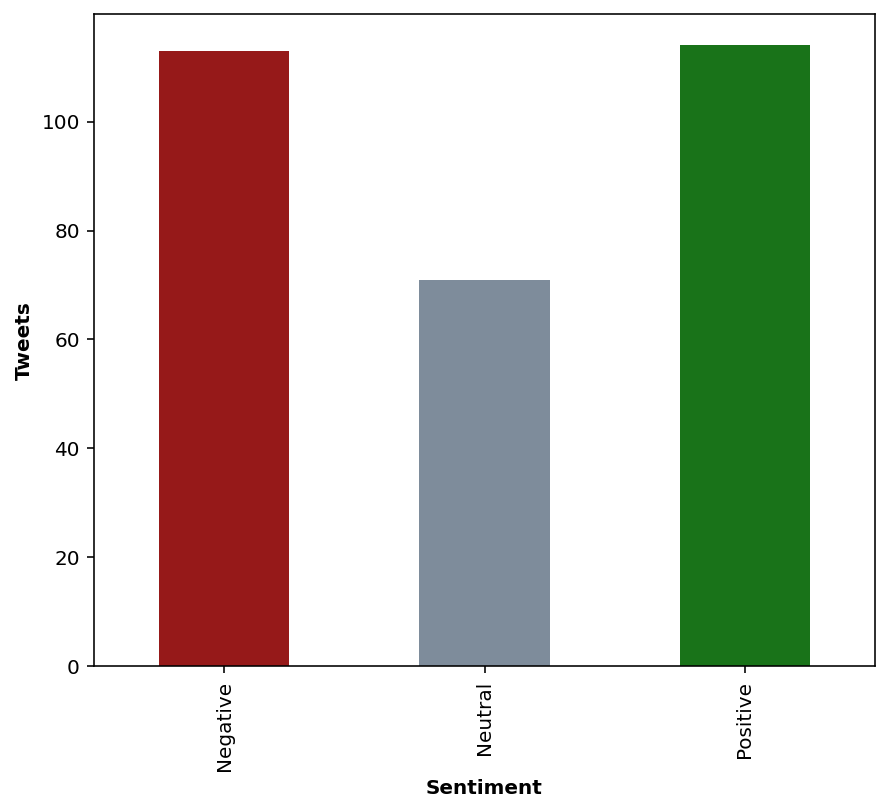

In [17]:
#Sentiment count
fig,ax = plt.subplots(figsize=(7,6))
df.groupby('senti').size().plot.bar(color=['darkred','slategray','darkgreen'],alpha=0.9)
plt.ylabel('Tweets',fontweight="bold")
plt.xlabel('Sentiment',fontweight="bold")
plt.xticks((0,1,2),('Negative','Neutral','Positive')) #0:Negative,2:Neutral,3:Positive

In [18]:
text_tf1 = SA.TF_IDF(df['tweet'], list(lexicon.keys()))

In [19]:
#tf-idf matrix
pd.DataFrame(text_tf1)

,0,1,2,3,4,5,6,7,8,9,...,1313,1314,1315,1316,1317,1318,1319,1320,1321,1322
0,0.082607,0.073353,0.072358,0.065314,0.06453,0.062282,0.061565,0.060863,0.053985,0.052874,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.161683,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
294,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
295,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.335043,0.335043,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
296,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.580965,0.580965,0.580965,0.000000,0.000000,0.000000,0.000000,0.000000


In [20]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(text_tf1, df['senti'], test_size=0.3, random_state=123)

In [21]:
# Model Generation Using Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))

MultinomialNB Accuracy: 0.6333333333333333


In [22]:
CM0 = confusion_matrix(y_test,predicted) 
print(classification_report(y_test,predicted)) 

              precision    recall  f1-score   support

           0       0.79      0.68      0.73        38
           2       1.00      0.10      0.18        20
           4       0.53      0.91      0.67        32

    accuracy                           0.63        90
   macro avg       0.77      0.56      0.53        90
weighted avg       0.74      0.63      0.59        90



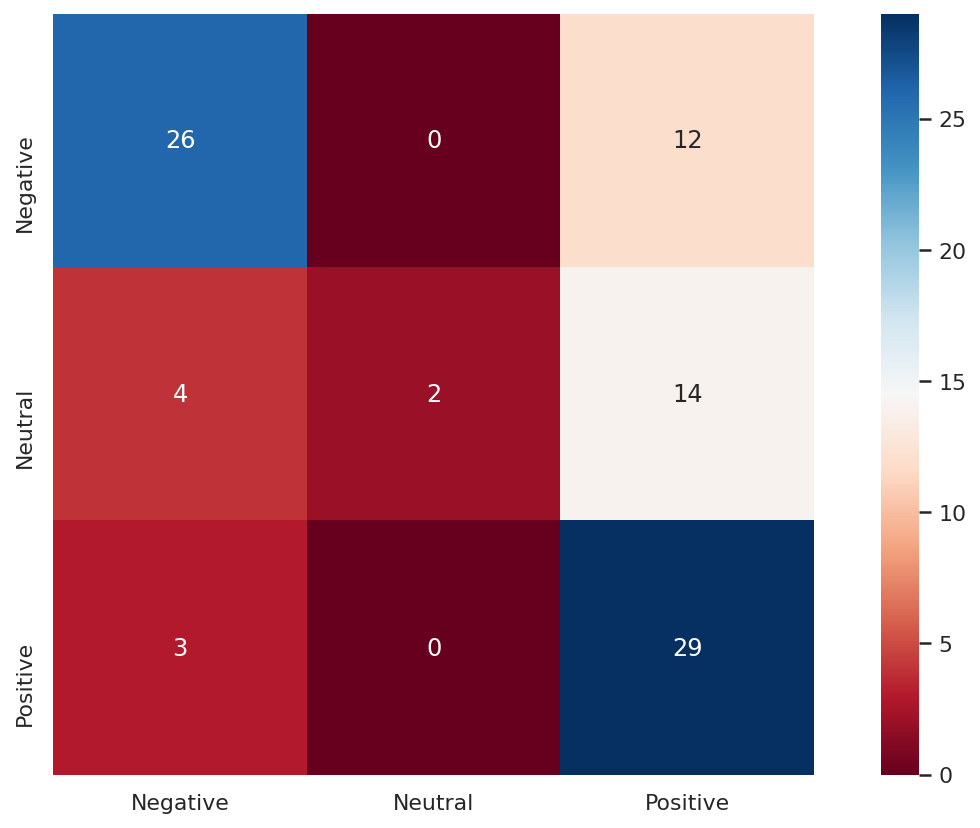

In [23]:
sns.set(font_scale=1)
sns.heatmap(CM0, cmap=plt.cm.RdBu, annot=True, square=True, fmt='d',
            xticklabels=['Negative', 'Neutral','Positive'],
            yticklabels=['Negative', 'Neutral','Positive']);

In [24]:
#Using Random Forest
from sklearn.ensemble import RandomForestClassifier
text_classifier = RandomForestClassifier(n_estimators=100, random_state=0)  
text_classifier.fit(X_train, y_train)
predictions = text_classifier.predict(X_test)
print(accuracy_score(y_test, predictions))

0.5777777777777777


In [25]:
CM = confusion_matrix(y_test,predictions) 
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.65      0.63      0.64        38
           2       0.20      0.05      0.08        20
           4       0.56      0.84      0.68        32

    accuracy                           0.58        90
   macro avg       0.47      0.51      0.47        90
weighted avg       0.52      0.58      0.53        90



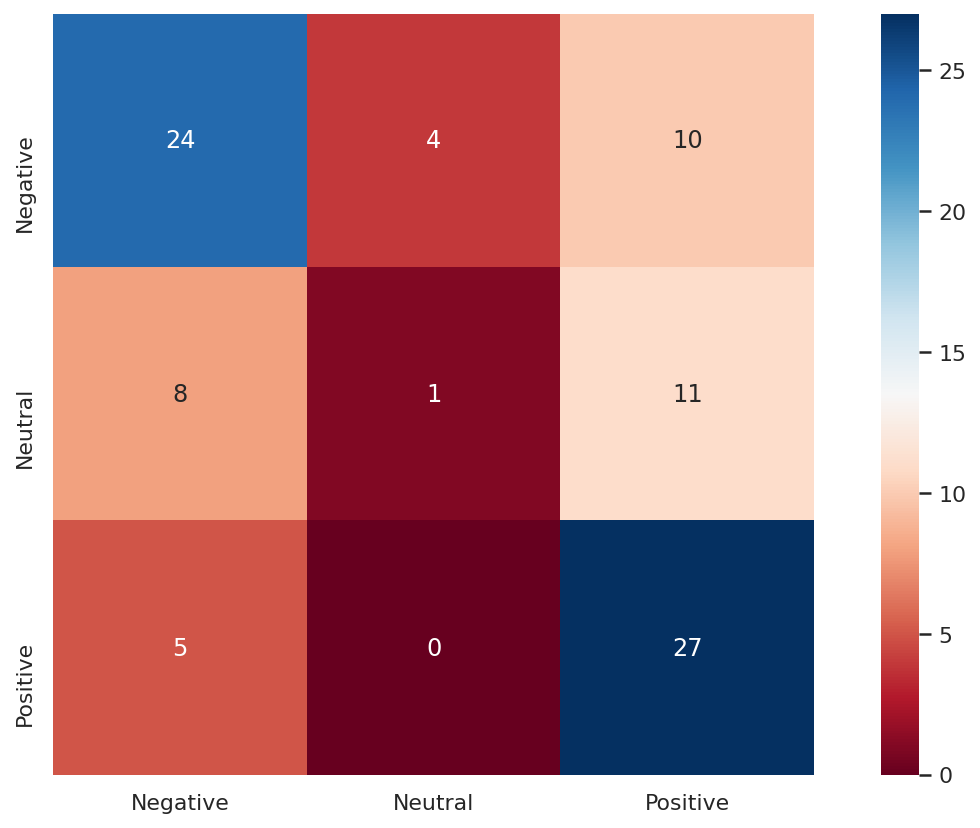

In [26]:
sns.set(font_scale=1)
sns.heatmap(CM, cmap=plt.cm.RdBu, annot=True, square=True, fmt='d',
            xticklabels=['Negative', 'Neutral','Positive'],
            yticklabels=['Negative', 'Neutral','Positive']);

In [27]:
#Using Logistic Regression
from sklearn.linear_model import LogisticRegression
LR_model = LogisticRegression(solver='lbfgs')
LR_model.fit(X_train, y_train)
y_predict_lr = LR_model.predict(X_test)
print(accuracy_score(y_test, y_predict_lr))

0.7


In [28]:
CM1 = confusion_matrix(y_test,y_predict_lr) 
print(classification_report(y_test,y_predict_lr))  

              precision    recall  f1-score   support

           0       0.72      0.76      0.74        38
           2       0.50      0.25      0.33        20
           4       0.72      0.91      0.81        32

    accuracy                           0.70        90
   macro avg       0.65      0.64      0.63        90
weighted avg       0.68      0.70      0.67        90



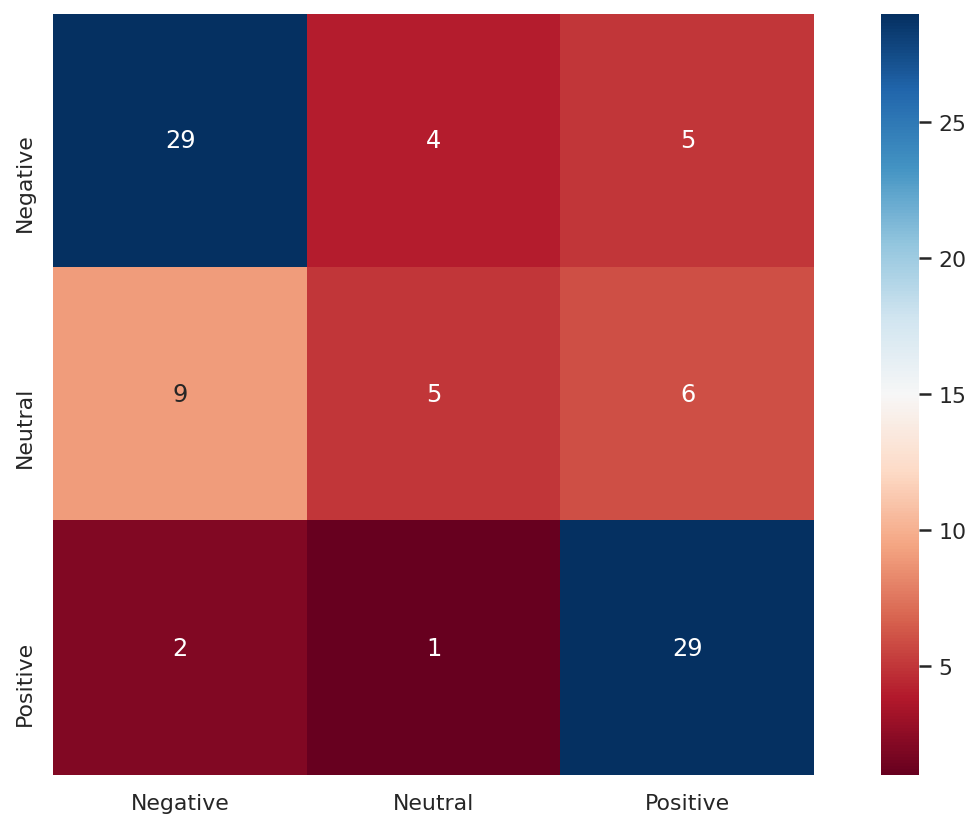

In [29]:
sns.set(font_scale=1)
sns.heatmap(CM1, cmap=plt.cm.RdBu, annot=True, square=True, fmt='d',
            xticklabels=['Negative', 'Neutral','Positive'],
            yticklabels=['Negative', 'Neutral','Positive']);

In [30]:
#SVM
from sklearn import svm
classifier_linear = svm.SVC(kernel='linear')
classifier_linear.fit(X_train, y_train)
prediction_linear = classifier_linear.predict(X_test)
print(accuracy_score(y_test, prediction_linear))

0.6333333333333333


In [31]:
CM2 = confusion_matrix(y_test,prediction_linear) 
print(classification_report(y_test,prediction_linear))  

              precision    recall  f1-score   support

           0       0.60      0.79      0.68        38
           2       0.50      0.25      0.33        20
           4       0.73      0.69      0.71        32

    accuracy                           0.63        90
   macro avg       0.61      0.58      0.57        90
weighted avg       0.63      0.63      0.61        90



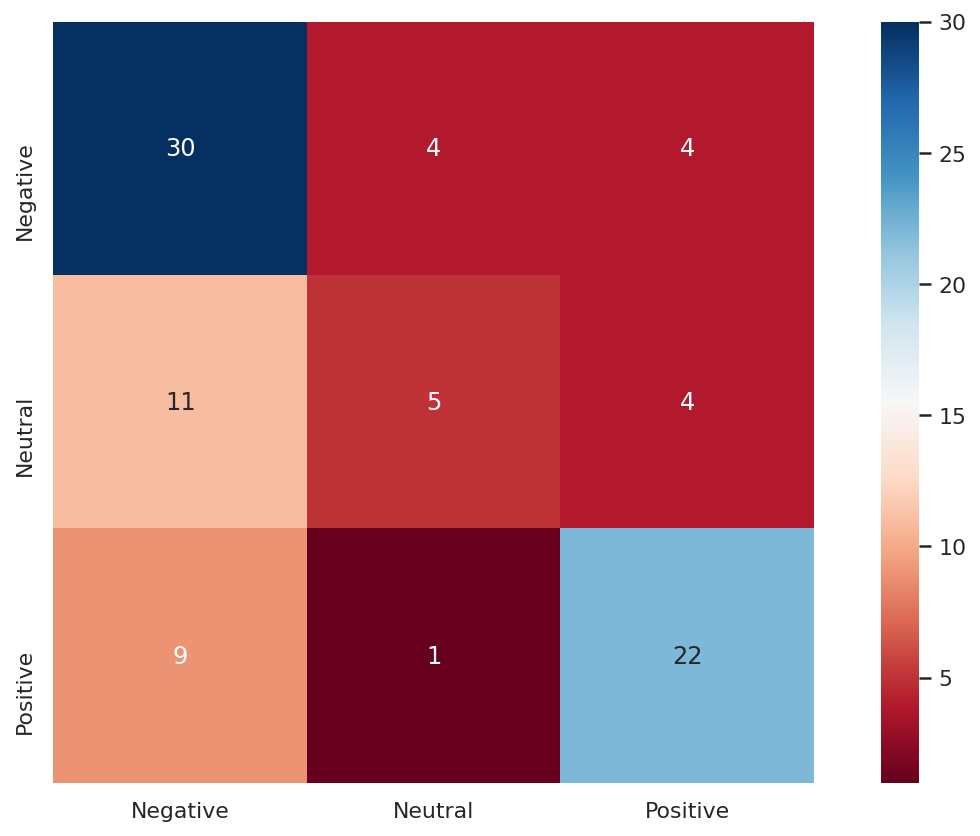

In [32]:
sns.set(font_scale=1)
sns.heatmap(CM2, cmap=plt.cm.RdBu, annot=True, square=True, fmt='d',
            xticklabels=['Negative', 'Neutral','Positive'],
            yticklabels=['Negative', 'Neutral','Positive']);